# ECE 253 Homework 3
#### Name: Sheng-Wei Chang
#### PID:  A53317226

Academic Integrity Policy: Integrity of scholarship is essential for an academic community. The University expects that both faculty and students will honor this principle and in so doing protect the validity of University intellectual work. For students, this means that all academic work will be done by the individual to whom it is assigned, without unauthorized aid of any kind. By including this in my report, I agree to abide by the Academic Integrity Policy mentioned above.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# from scipy.signal import convolve
# import warnings
# warnings.filterwarnings('ignore')

## Problem 1. Hough Transform

In [2]:
# (i)
def hough(img):
    # Rho and Theta
    width, height = img.shape
    max_dist = np.ceil(np.sqrt(width**2 + height**2))   #  diagonal length
    rhos = np.linspace(-max_dist, max_dist, int(2*max_dist))
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    
    # Hough accumulator array of theta vs rho
    accumulator = np.zeros(( int(2*max_dist), len(thetas)), dtype=int)
    rows, cols = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(rows)):
        r = rows[i] # y
        c = cols[i] # x

        for t_idx in range(len(thetas)):
            # Calculate rho. max_dist is added for a positive index
            rho = int(round(c*np.cos(thetas)[t_idx] + r*np.sin(thetas)[t_idx]) + max_dist)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def thresholding(HT, thre=None, thre_theta=None):
    if thre is None:
        thre = 0.75 * np.max(HT)
    rho_max, theta_max = HT.shape[0]/2, HT.shape[1]/2
    parameters = np.argwhere(HT > thre)
    parameters[:,0] = parameters[:,0] - rho_max
    parameters[:,1] = theta_max - parameters[:,1]
    lines = []
    for p in parameters:
        rho, theta = p[0], p[1]
        if (thre_theta is None) or ((theta > thre_theta[0]) and (theta < thre_theta[1])):
            x1, x2 = 100*int(round(rho/np.cos(np.deg2rad(theta)))), (-99)*int(round(rho/np.cos(np.deg2rad(theta))))
            y1, y2 = 99*int(round(rho/np.sin(np.deg2rad(theta)))), (-100)*int(round(rho/np.sin(np.deg2rad(theta))))
            lines.append([[x1, x2], [y1, y2]])
    return lines

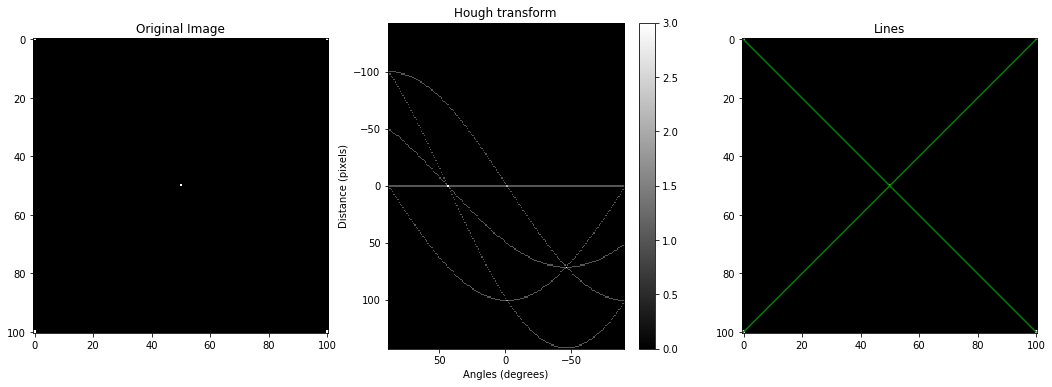

In [3]:
# (ii)
w, h = 101, 101
test = np.zeros((w,h))
white = [(0,0),(0,-1),(-1,0),(-1,-1),(w//2,h//2)]
for point in white:
    test[point] = 1
accumulator, thetas, rhos = hough(test)
lines = thresholding(accumulator)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Original image
ax[0].imshow(test, cmap='gray')
ax[0].set_title('Original Image')

# Hough transform
f = ax[1].imshow(accumulator, cmap='gray', extent=[np.rad2deg(thetas[-1]),np.rad2deg(thetas[0]),rhos[-1],rhos[0]])
ax[1].set_aspect('auto')
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
fig.colorbar(f, ax=ax[1])

# Lines on the original image
ax[2].imshow(test, cmap='gray')
ax[2].plot([100,0], [0,100], 'g')
ax[2].plot([0,100], [0,100], 'g')
ax[2].set_title('Lines')

plt.show()

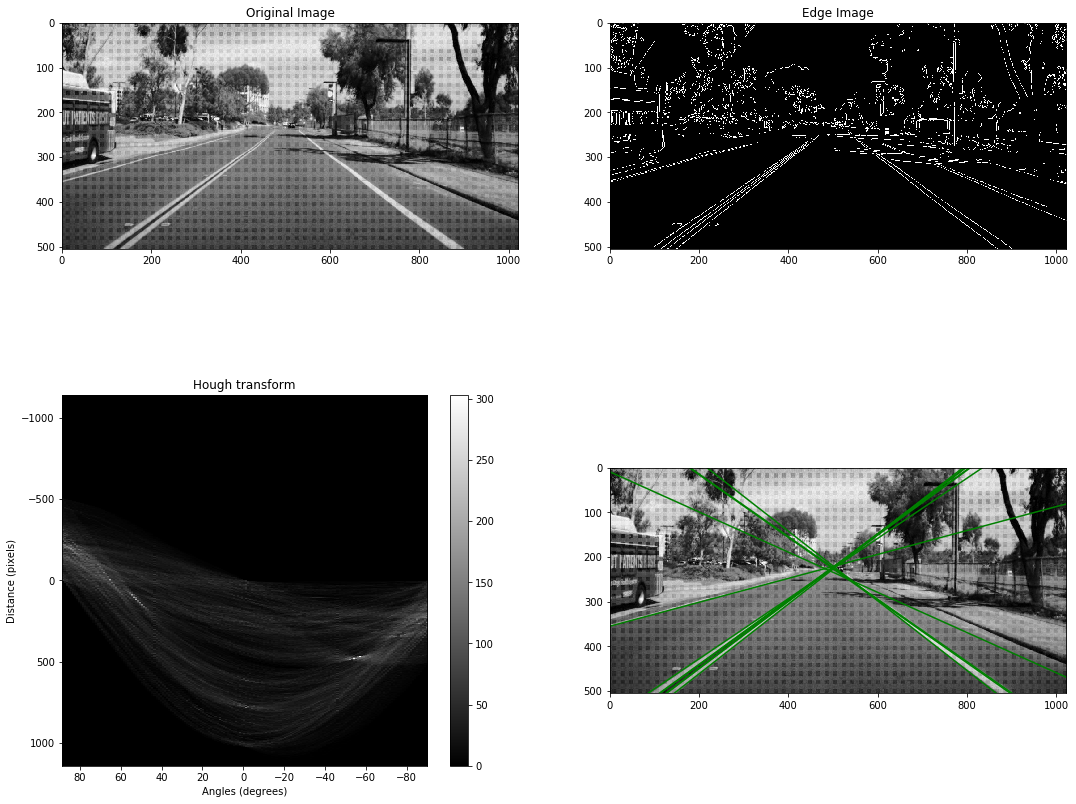

In [4]:
# (iii)
img = cv2.imread('images/lane.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edges = cv2.Canny(img, 200, 300)
accumulator, thetas, rhos = hough(edges)
lines = thresholding(accumulator)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(18, 15))

# Original image
ax[0,0].imshow(img, cmap='gray')
ax[0,0].set_title('Original Image')

# Edge image
ax[0,1].imshow(edges, cmap='gray')
ax[0,1].set_title('Edge Image')

# Hough transform
f = ax[1,0].imshow(accumulator, cmap='gray', extent=[np.rad2deg(thetas[-1]),np.rad2deg(thetas[0]),rhos[-1],rhos[0]])
ax[1,0].set_aspect('auto')
ax[1,0].set_title('Hough transform')
ax[1,0].set_xlabel('Angles (degrees)')
ax[1,0].set_ylabel('Distance (pixels)')
fig.colorbar(f, ax=ax[1,0])

# Lines on the original image
ax[1,1].imshow(img, cmap='gray')
for l in lines:
    ax[1,1].plot(l[0], l[1], 'g')
ax[1,1].set_xlim(0, img.shape[1])
ax[1,1].set_ylim(img.shape[0], 0)

plt.show()

The approximate theta values for the two lines in the driver's lane are 55 degrees and -54 degrees.


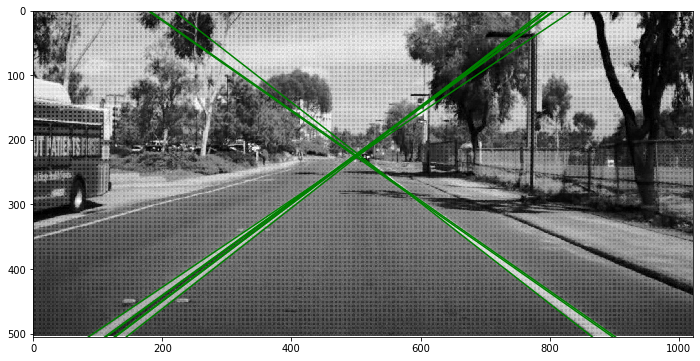

In [5]:
# (iv)
lines = thresholding(accumulator, thre_theta=[-57, 57])
print('The approximate theta values for the two lines in the driver\'s lane are 55 degrees and -54 degrees.')

# Plot
plt.figure(figsize=(18,6))
plt.imshow(img, cmap='gray')
for l in lines:
    plt.plot(l[0], l[1], 'g')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)

plt.show()

## Problem 2. K-Means Segmentation

In [6]:
def createDataset(img):
    return img.reshape(img.shape[0]*img.shape[1], 3).astype(int)

def kMeansCluster(features, centers):
    '''This function is intended to perform K-Means based clustering on the dataset features (of size NxM).
    Input:
        features: Each row in features represents a data point, and each column represents a feature.
        centers: (kxM) Each row is the initial value of a cluster center.
    Output:
        classes: (Nx1) vector that stores the final cluster membership (1; 2; ... ; k) of each data point.
        centers: the final cluster centers after K-Means.
    Note that you may need to set a maximum iteration count to exit K-Means in case the algorithm fails to converge.
    '''
    iteration = 100
    dist = np.zeros((features.shape[0], centers.shape[0]))
    classes = np.zeros(features.shape[0])
    
    for it in range(iteration):
        # Assignment
        for k in range(centers.shape[0]):
            dist[:,k] = np.linalg.norm(features-centers[k], axis=1)
        classes = np.argmin(dist, axis=1)
        
        # Update
        for k in range(centers.shape[0]):
            idx = np.argwhere(classes == k).T[0]
            centers[k,:] = np.mean(features[idx, :], axis=0)

    return classes, centers

def mapValues(img, classes, centers):
    ''' This function is intened to show the segmented image.
    Input:
        img
        classes: (Nx1) vector that stores the final cluster membership (1; 2; ... ; k) of each data point.
        centers: (kxM) Each row is the initial value of a cluster center.
    Output:
        img_seg: Each pixel in the segmented image must have the RGB value of the cluster center to which it belongs.
    '''
    classes = classes.reshape((img.shape[0], img.shape[1]))
    img_seg = centers[classes]
    
    return img_seg

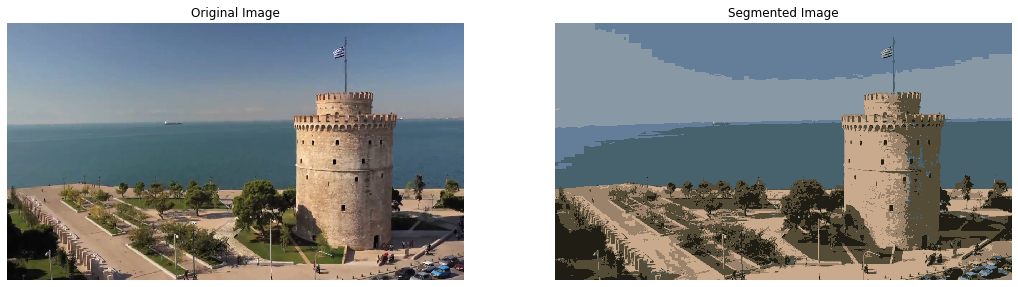

The final cluster centers that you obtain after K-Means:
Cluster 0: [137 152 165]
Cluster 1: [ 72  98 109]
Cluster 2: [85 76 56]
Cluster 3: [100 125 153]
Cluster 4: [155 130 107]
Cluster 5: [202 170 141]
Cluster 6: [32 29 21]


In [7]:
img = cv2.imread('images/white-tower.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# initialization
features = createDataset(img)
nclusters = 7
np.random.seed(5)
index = np.random.randint(features.shape[0], size=nclusters)
centers = features[index, :]

# k-means
classes, centers = kMeansCluster(features, centers)
img_seg = mapValues(img, classes, centers)

# plot
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Segmented Image')
plt.imshow(img_seg)
plt.axis('off')

plt.show()

print('The final cluster centers that you obtain after K-Means:')
for i, c in enumerate(centers):
    print('Cluster %d:' %i, c)